# About the Project
This project presents a comprehensive analysis of India's electric vehicle market, focusing on segmentation derived from sales data, customer reviews, and technical specifications.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

In [2]:
!pip install missingno
import missingno as msno 

In [3]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# warnings.filterwarnings("ignore")
# pd.options.display.max_columns = None

# Sales Data
The sales data obtained from the Society of Manufacturers of Electric Vehicles, spanning 2017 to 2023, catalogues sales figures of electric two-wheelers, three-wheelers, four-wheelers, and buses. This dataset provides a comprehensive view of market trends and customer preferences over time.

In [6]:
data_smev = pd.read_excel("smev_data.xlsx", sheet_name=None)

In [7]:
print(data_smev.keys())
len(data_smev.keys())

dict_keys(['EV 2W FY 19-20', 'EV 2W FY 20-21', 'EV 2W FY 21-22', 'EV 2W FY 22-23', 'EV Market', 'Electric Bus Sales', 'Electric 4-Wheeler Sales', 'Electric 3-Wheeler Sales', 'Electric 2-Wheeler Sales', 'EV Industries'])


10

### There are 10 different excel sheet present in **smev_data**
## Lets analysis the EV Idustries data first

In [8]:
data_smev['EV Industries']

,category,financial_year,num_vehicles
0,E-2 Wheelers,2017-18,1981
1,E-2 Wheelers,2018-19,27478
2,E-2 Wheelers,2019-20,26512
3,E-2 Wheelers,2020-21,44294
4,E-2 Wheelers,2021-22,249615
5,E-2 Wheelers,2022-23,728090
6,E-3 Wheelers,2017-18,91970
7,E-3 Wheelers,2018-19,116031
8,E-3 Wheelers,2019-20,143051
9,E-3 Wheelers,2020-21,90898


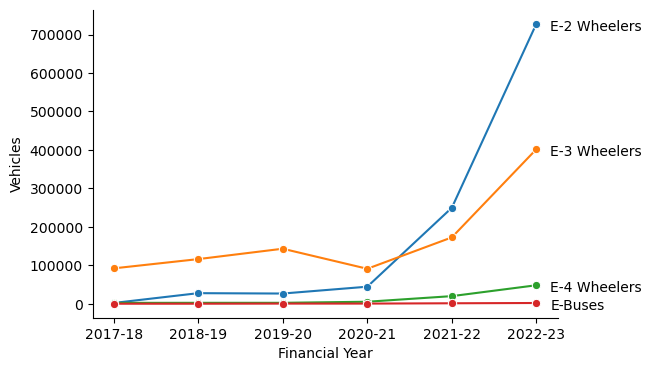

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=data_smev['EV Industries'], x='financial_year', y='num_vehicles', hue='category', marker='o', palette='tab10')
plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.legend(title='Category')

# Annotate the last data point
for col in data_smev['EV Industries']['category'].unique():
    last_point = data_smev['EV Industries'][data_smev['EV Industries']['category'] == col].iloc[-1]
    plt.annotate(f"{last_point['category']}",
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5),
                 ha='left')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.show()

**Above Figure showcased the remarkable growth trajectory of India's two-wheeler market in 2023, underscoring its leading position within the industry.**

In [10]:
data_smev['EV Market'] = data_smev['EV Market'].sort_values('Amount INR Cr', ascending = False)
data_smev['EV Market']

,Category,Amount INR Cr
0,E-2 Wheelers,2464.27
3,E-Buses,687.93
1,E-3 Wheelers,351.21
2,E-4 Wheelers,114.65


**Sort the EV Market column of the DataFrame data_smev based on the Amount INR Cr values in descending order. Which shows that 2-Wheelers sales is in the top.**

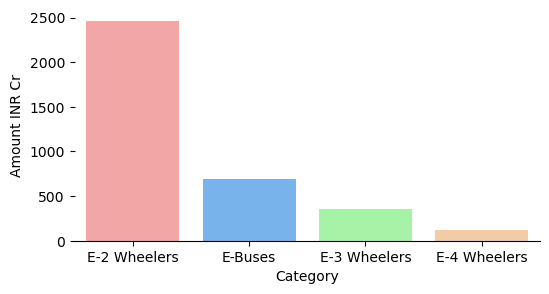

In [11]:
# List of colors for each bar
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# creating the plot
fig, ax = plt.subplots(figsize = (6, 3))
bars = sns.barplot(data_smev['EV Market'], x = 'Category', y = 'Amount INR Cr',palette=colors,ax=ax)
# plt.xlabel("Category")
# plt.ylabel("Amount INR Cr")
#ax.bar_label(bars.containers[0])
#plt.yticks([])
#plt.ylabel("")
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.show()

**Above Figure delved into the market's financial perspective, representing the industry's total value in crores. Notably, two-wheelers emerged as the primary revenue generators, highlighting their economic significance.**

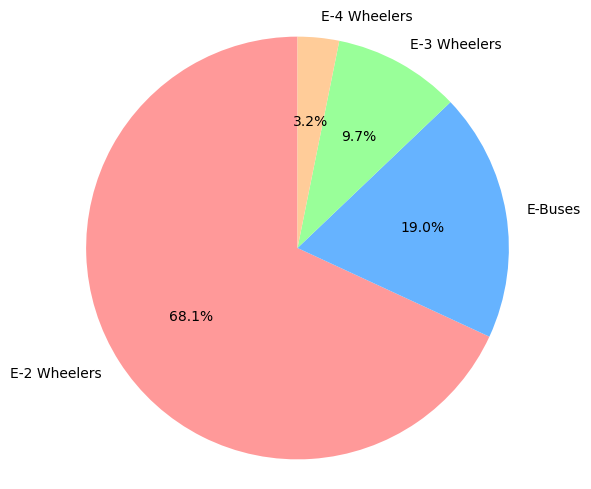

In [12]:
data = data_smev['EV Market']

# List of colors for the pie chart
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Creating the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(data['Amount INR Cr'], labels=data['Category'], colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.show()

### The above Pie chart shows the dominance of market revenue of **E-2 Wheelers** in  the market.

## Lets start working in the domain of 2 wheeler

In [13]:

ev2w = list(data_smev.keys())[0:4]
data_ev2w = pd.concat([data_smev[ev2w[0]], data_smev[ev2w[1]], data_smev[ev2w[2]], data_smev[ev2w[3]]])
data_ev2w

,financial_year,maker,market_share,month,num_vehicles
0,2019-20,Hero Electric,0.30,Apr,1776
1,2019-20,Hero Electric,0.30,May,455
2,2019-20,Hero Electric,0.30,Jun,329
3,2019-20,Hero Electric,0.30,Jul,260
4,2019-20,Hero Electric,0.30,Aug,249
...,...,...,...,...,...
151,2022-23,OTHERS,0.08,Nov,5241
152,2022-23,OTHERS,0.08,Dec,5233
153,2022-23,OTHERS,0.08,Jan,5111
154,2022-23,OTHERS,0.08,Feb,5083


In [14]:
data_ev2w['maker'] = data_ev2w['maker'].str.upper()
data_ev2w['maker'].unique()

array(['HERO ELECTRIC', 'OKINAWA AUTOTECH', 'ATHER ENERGY',
       'AMPERE VEHICLES', 'REVOLT', 'OTHERS', 'BAJAJ', 'PURE EV',
       'BENLING', 'JITENDRA', 'TVS', 'OLA ELECTRIC', 'OKINAWA', 'AMPERE',
       'ATHER', 'OKAYA EV', 'BEING INDIA', 'JITENDRA NEW EV'],
      dtype=object)

#### Since here few companies have different name, so it will be better to give same name and merge them together.

In [15]:
data_ev2w['maker'] = data_ev2w['maker'].replace('AMPERE VEHICLES', 'AMPERE').replace('ATHER ENERGY', 'ATHER').replace('BEING INDIA', 'BENLING').replace('JITENDRA NEW EV', 'JITENDRA').replace('OKINAWA AUTOTECH', 'OKINAWA')

In [16]:
np.sort(data_ev2w['maker'].unique())

array(['AMPERE', 'ATHER', 'BAJAJ', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'OKAYA EV', 'OKINAWA', 'OLA ELECTRIC', 'OTHERS', 'PURE EV',
       'REVOLT', 'TVS'], dtype=object)

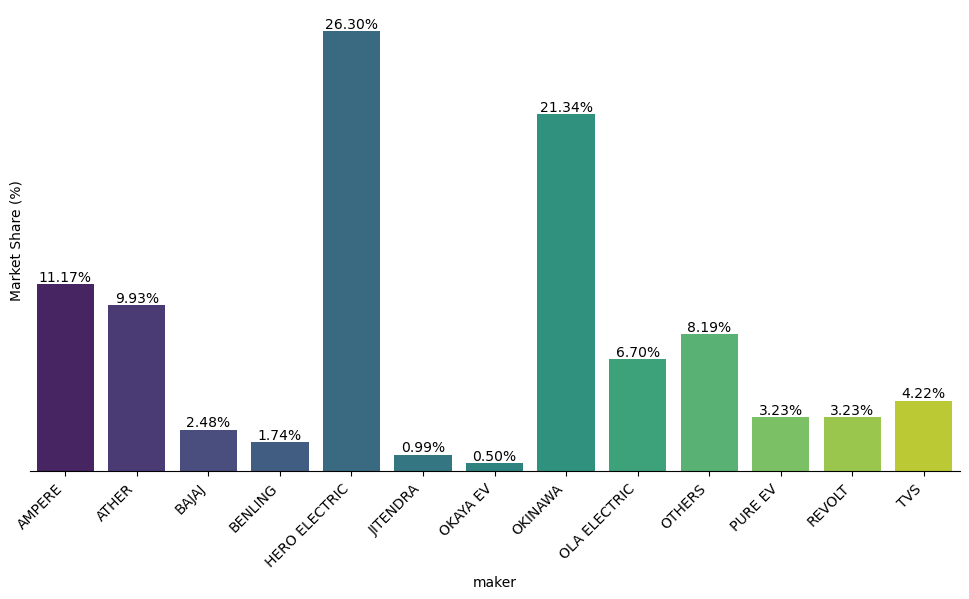

In [17]:
# Group by 'maker' and sum the 'market_share'
grouped_data = data_ev2w.groupby('maker')['market_share'].sum().reset_index()

# Calculate the total market share
total_market_share = grouped_data['market_share'].sum()

# Calculate the market share percentage
grouped_data['market_share_pct'] = (grouped_data['market_share'] / total_market_share) * 100

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=grouped_data, x='maker', y='market_share_pct', palette='viridis')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge')

# Remove y-ticks and y-label
plt.yticks([])
plt.ylabel("Market Share (%)")

# Remove unwanted spines
ax.spines[['right', 'top', 'left']].set_visible(False)

# Show the plot
plt.show()

Which shows **Hero Electric** and **Okinwawa Autotech** are having the top two market share company in the 2 wheeler industry. Together they have around 50% market share.

In [18]:


# figsize = (12, 1.2 * len(data_ev2w['financial_year'].unique()))
# plt.figure(figsize=figsize)
# sns.violinplot(data_ev2w, x='market_share', y='financial_year', inner='box', palette='Dark2')
# sns.despine(top=True, right=True, bottom=True, left=True)

In [19]:
data_ev2w_year = data_ev2w.groupby(['financial_year', 'maker']).agg({'num_vehicles':'sum'}).reset_index()
data_ev2w_year

,financial_year,maker,num_vehicles
0,2019-20,AMPERE,2518
1,2019-20,ATHER,2905
2,2019-20,HERO ELECTRIC,7865
3,2019-20,OKINAWA,10135
4,2019-20,OTHERS,2026
5,2019-20,REVOLT,1063
6,2020-21,AMPERE,6089
7,2020-21,ATHER,4401
8,2020-21,BAJAJ,1470
9,2020-21,BENLING,1108


The above table shows the company wise vehical sell in a financial year.

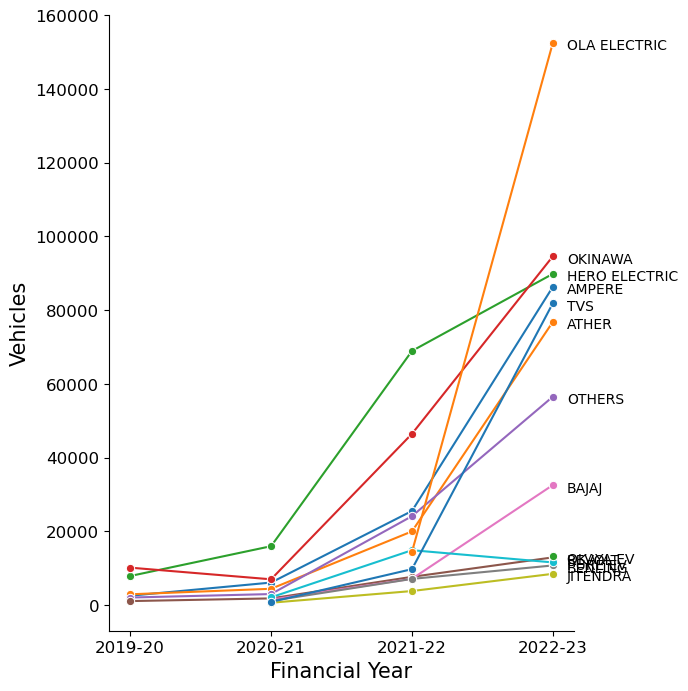

In [20]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.lineplot(data=data_ev2w_year, x='financial_year', y='num_vehicles', hue='maker', marker='o', palette='tab10')
plt.xlabel("Financial Year", fontsize = 15)
plt.ylabel("Vehicles", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title='Maker')

# Annotate the last data point
for col in data_ev2w_year['maker'].unique()[::1]:
    last_point = data_ev2w_year[data_ev2w_year['maker'] == col].iloc[-1]
    plt.annotate(f"{last_point['maker']}",
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5),
                 ha='left')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.show()

**Above Figure honed in on specific electric two-wheeler companies, with Ola Electric emerging as the market leader in 2023, illustrating industry leadership and market competitiveness.**

# EV Market Segmentation

* The dataset used for the market segmentation analysis, extracted from bikewale.com, comprises electric two-wheeler customer reviews, offering vital behavioral and psychographic insights.
* It also presents detailed technical specifications and pricing information of electric two-wheelers. This data allowed us to assess the technical feasibility and price points crucial for our market segmentation strategy


In [21]:
data_bw = pd.read_csv("ev2_bikewale.csv")
data_bw.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube


In [22]:


# Find column names
column_names = data_bw.columns
print("Column Names:", column_names)

print(f'Shape of data: {data_bw.shape}')

print(f"Model count: {data_bw['Model Name'].nunique()}")

Column Names: Index(['review', 'Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'Model Name'],
      dtype='object')
Shape of data: (844, 14)
Model count: 39


In [23]:
data_model = pd.read_csv("ev_model_spec.csv")
data_model.head()

,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,Ampere Magnus EX,104758,121,53,90,7,1200
1,Ampere Magnus Pro,66053,45,25,94,10,250
2,Ampere REO,61993,45,25,88,10,250
3,Ampere Zeal,96544,120,53,80,7,1200
4,Ather 450X,135489,111,90,108,8,3000


In [24]:
print(data_model.shape)

(39, 7)


### Merging the both data set to get all over representation of the market

In [25]:
data = data_bw.merge(data_model, how = 'left', on = 'Model Name')

In [26]:
data.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000


In [27]:
data['Used it for'].unique()

array(['Daily Commute', 'Everything', 'Occasional Commute',
       'Leisure Rides', 'Tours'], dtype=object)

          Used it for  Count
0       Daily Commute    600
1          Everything    160
2       Leisure Rides     20
3  Occasional Commute     56
4               Tours      8


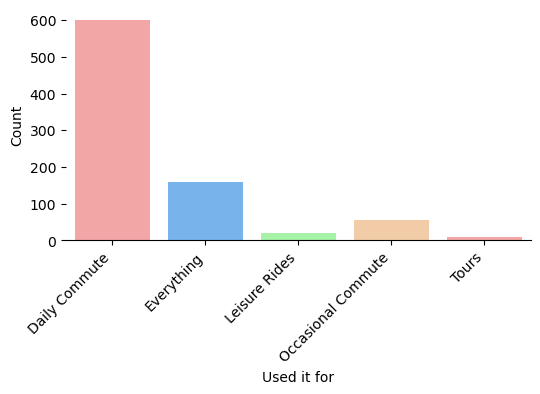

In [28]:
# Group by 'Used it for' and count occurrences
Used_counts = data.groupby('Used it for').size().reset_index(name='Count')
print(Used_counts)

# List of colors for each bar
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# creating the plot
fig, ax = plt.subplots(figsize = (6, 3))
bars = sns.barplot(Used_counts, x = 'Used it for', y = 'Count',palette=colors,ax=ax)
# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

#ax.bar_label(bars.containers[0])
# plt.yticks([])
# plt.ylabel("")
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.show()

### From this barplot it's clear that most people used it for **Daily Commute**

## Segmenting a particular sector where the bike are used for **Daily Commute**

In [29]:

data_used = data[data['Used it for']=='Daily Commute']

# Drop the 'Used it for' column
data_used = data_used.drop(columns=['Used it for'])

print(data_used.shape)
data_used.head()

(600, 19)


,review,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,We all checked the bike's capacity to be 150 k...,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
2,I purchased this in April 2022 and the sales s...,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
3,If any issues come in scooty parts not availab...,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
4,Don't buy this vehicle unless you have a near ...,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
5,First 7k kms no issues.\nLater rear wheel had ...,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000


<Axes: >

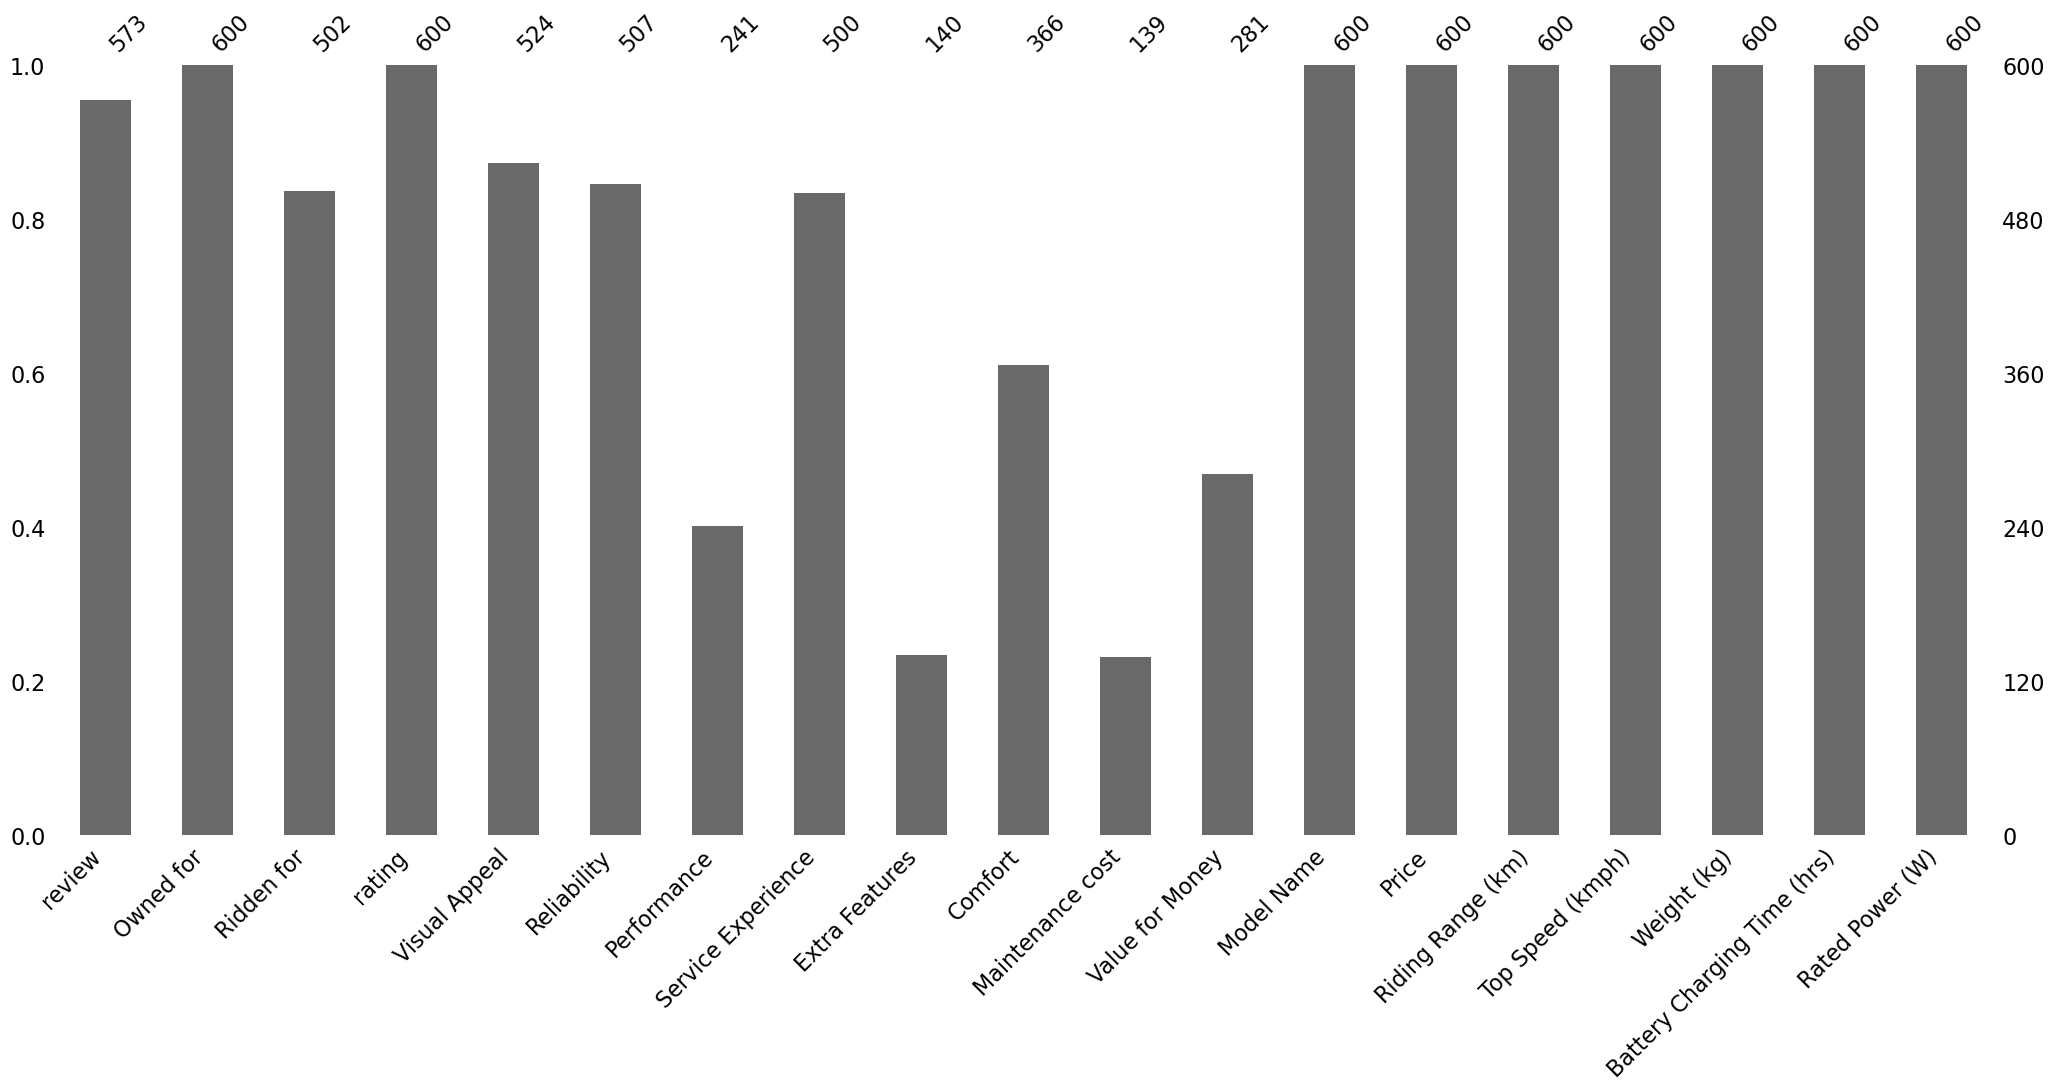

In [30]:
# Bar plot of non-missing values
msno.bar(data_used)

Displays a **bar plot** of the **total non-missing values** for each column in the DataFrame. This helps in quickly identifying columns with missing data.
As **Extra Features** and **Maintenance cost** are two highest column with missing values.

<Axes: >

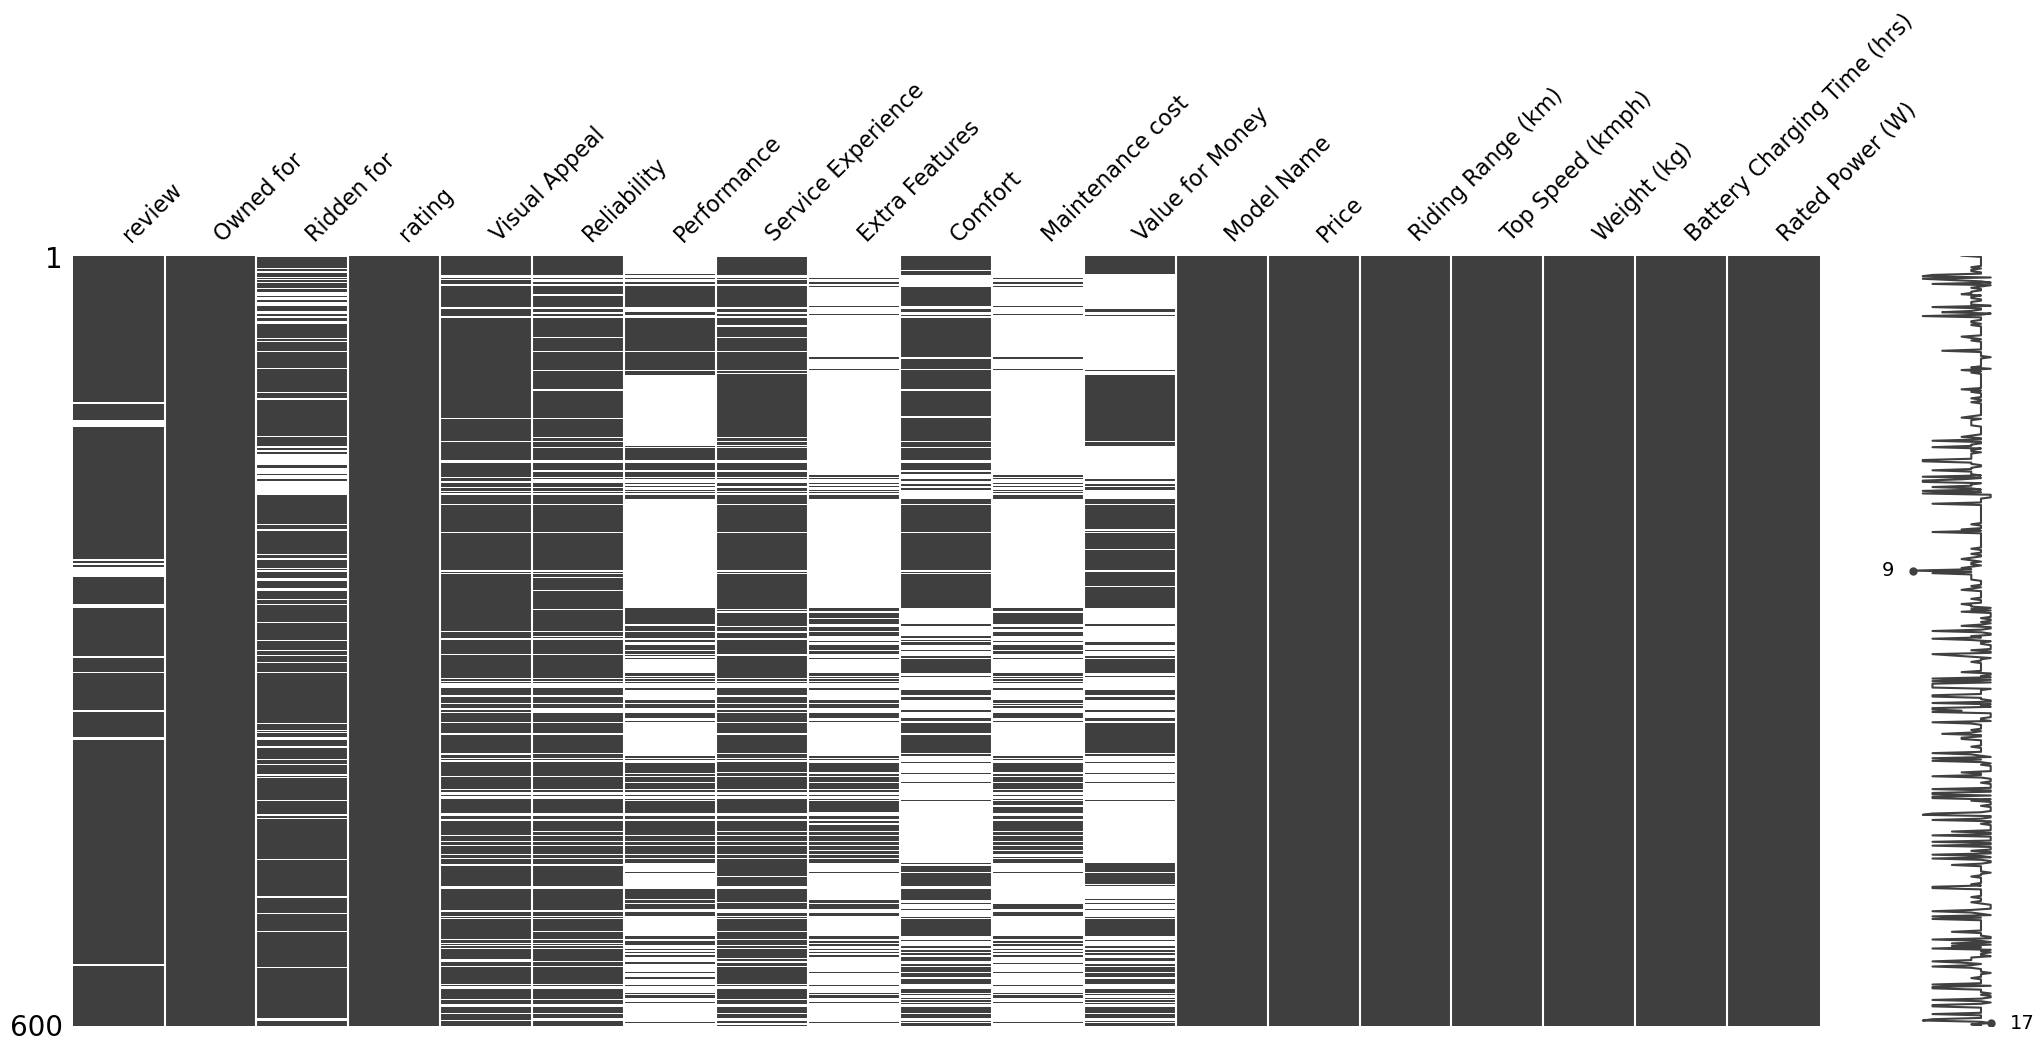

In [31]:
msno.matrix(data_used)

### We can use msno.matrix(data_used) also to get the **Missing values** which are marked as gaps, making it easy to see the pattern of missingness.

In [32]:
((data_used.isnull().sum() * 100/data.shape[0])).sort_values(ascending = False)

Maintenance cost               54.620853
Extra Features                 54.502370
Performance                    42.535545
Value for Money                37.796209
Comfort                        27.725118
Service Experience             11.848341
Ridden for                     11.611374
Reliability                    11.018957
Visual Appeal                   9.004739
review                          3.199052
Owned for                       0.000000
rating                          0.000000
Model Name                      0.000000
Price                           0.000000
Riding Range (km)               0.000000
Top Speed (kmph)                0.000000
Weight (kg)                     0.000000
Battery Charging Time (hrs)     0.000000
Rated Power (W)                 0.000000
dtype: float64

### This Column show the in each column how many values are missing in percentage wise
 The **Maintenance cost** and **Extra Feature** are top two column where around 50% values are missing

In [35]:
sentiments = SentimentIntensityAnalyzer()
sentiments_list = []

for review_text in data_used['review']:
    if pd.isna(review_text):
        sentiments_list.append('neutral')
        continue
    sentiment_scores = sentiments.polarity_scores(review_text)

    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']

    if positive_score > negative_score:
        sentiment_label = 'positive'
    elif positive_score < negative_score:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    sentiments_list.append(sentiment_label)

data_used['sentiment'] = sentiments_list

In [36]:
data_used['sentiment'].value_counts()

positive    363
negative    206
neutral      31
Name: sentiment, dtype: int64

In [ ]:
data_used = data_used.drop(columns=['review'])

In [41]:
print(data_used.shape)
data_used.head()


(600, 19)


,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
2,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,positive
3,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
4,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative
5,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative


### This will analys the sentiment from the review column then add as a sentiment column in the data set for further analysis

In [42]:
Sentiment_map = {'positive':1,'negative':-1,'neutral':0}
data_used.loc[:,'sentiment'] = data_used['sentiment'].map(Sentiment_map)


C:\Users\HP\AppData\Local\Temp\ipykernel_31872\148295914.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_used.loc[:,'sentiment'] = data_used['sentiment'].map(Sentiment_map)


In [43]:
data_used.head()

,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
2,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,1
3,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
4,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1
5,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1


C:\Users\HP\AppData\Local\Temp\ipykernel_31872\1755816960.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_data_used = data_used.corr()


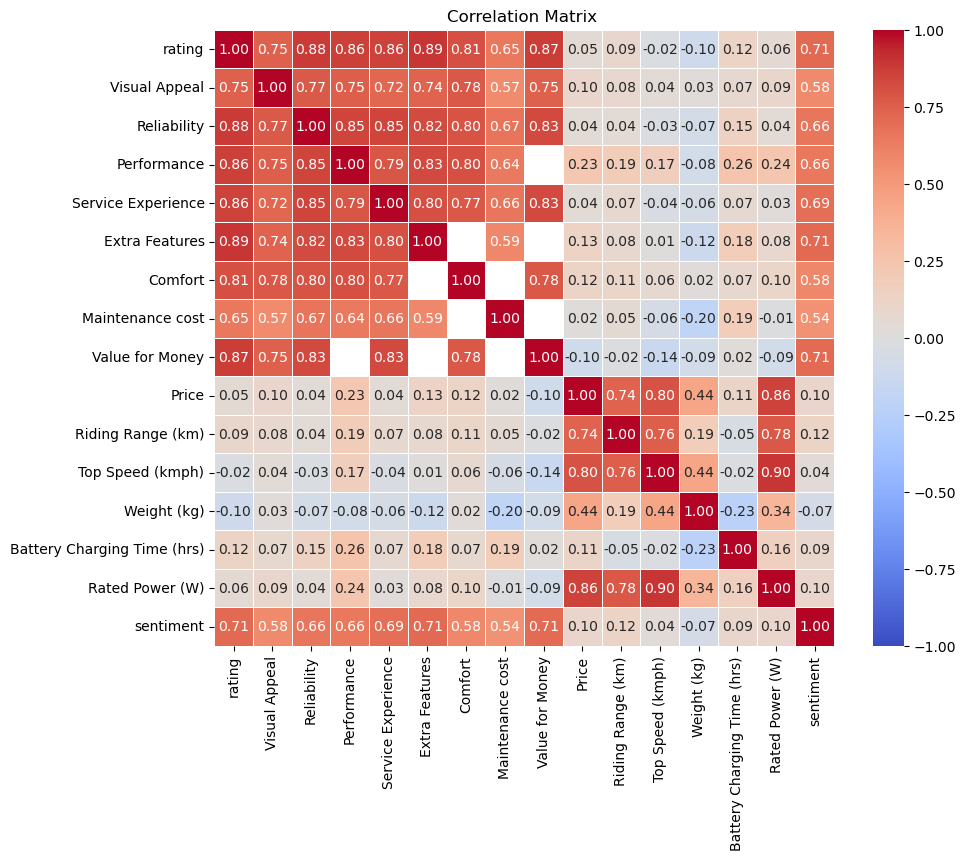

In [44]:
corr_data_used = data_used.corr()

# Create heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_data_used,annot=True,cmap='coolwarm',vmin=-1,vmax=1,fmt='.2f',linewidths=0.5)
plt.title('Correlation Matrix ')
plt.show()

In [46]:
data_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 843
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Owned for                    600 non-null    object 
 1   Ridden for                   502 non-null    object 
 2   rating                       600 non-null    int64  
 3   Visual Appeal                524 non-null    float64
 4   Reliability                  507 non-null    float64
 5   Performance                  241 non-null    float64
 6   Service Experience           500 non-null    float64
 7   Extra Features               140 non-null    float64
 8   Comfort                      366 non-null    float64
 9   Maintenance cost             139 non-null    float64
 10  Value for Money              281 non-null    float64
 11  Model Name                   600 non-null    object 
 12  Price                        600 non-null    int64  
 13  Riding Range (km)   

In [45]:
data_used.describe()

,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
count,600.000000,524.000000,507.000000,241.000000,500.000000,140.000000,366.000000,139.000000,281.000000,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.000000
mean,3.228333,3.708015,3.187377,3.448133,3.014000,2.907143,3.516393,3.460432,3.259786,96755.058333,104.068333,53.855000,100.951667,5.29500,1504.833333,0.261667
std,1.697351,1.363500,1.572490,1.479867,1.612142,1.604384,1.411694,1.358101,1.511900,28755.345917,32.521117,22.767108,28.743573,1.75588,1270.370566,0.938793
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51094.000000,45.000000,25.000000,59.000000,3.00000,250.000000,-1.000000
25%,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,3.000000,2.500000,2.000000,73124.000000,85.000000,25.000000,76.000000,4.00000,250.000000,-1.000000
50%,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,90282.000000,90.000000,58.000000,93.000000,5.00000,1200.000000,1.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,110376.000000,120.000000,60.000000,125.000000,6.00000,2425.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,167844.000000,180.000000,116.000000,150.000000,10.00000,5500.000000,1.000000


In [47]:
#data_used['Visual Appeal'].unique()

array([ 3.,  4.,  1.,  5.,  2., nan])

In [35]:
# Compute the correlation matrix
# correlation_matrix = data.corr()

# # Display the correlation matrix
# print(correlation_matrix)

# # Visualize the correlation matrix using a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

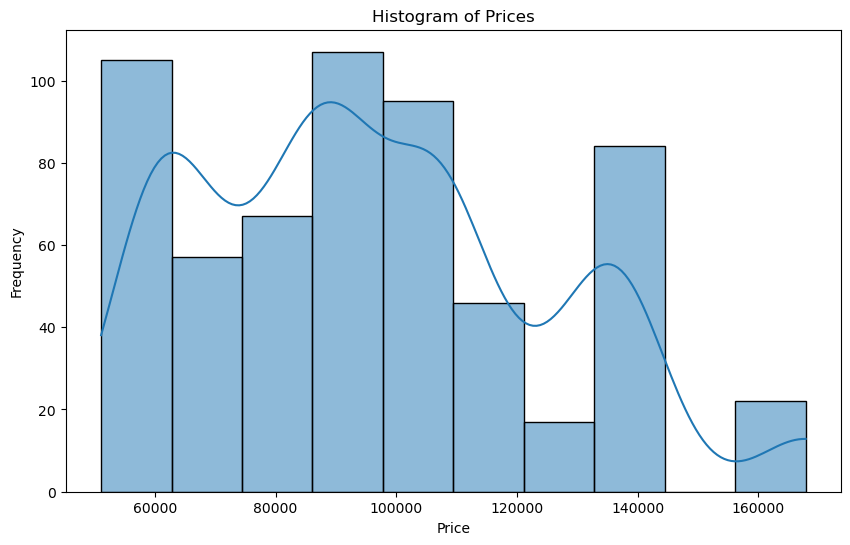

In [97]:
plt.figure(figsize=(10,6))

sns.histplot(data_used['Price'],kde=True,bins=10,edgecolor='black')

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')

plt.show()

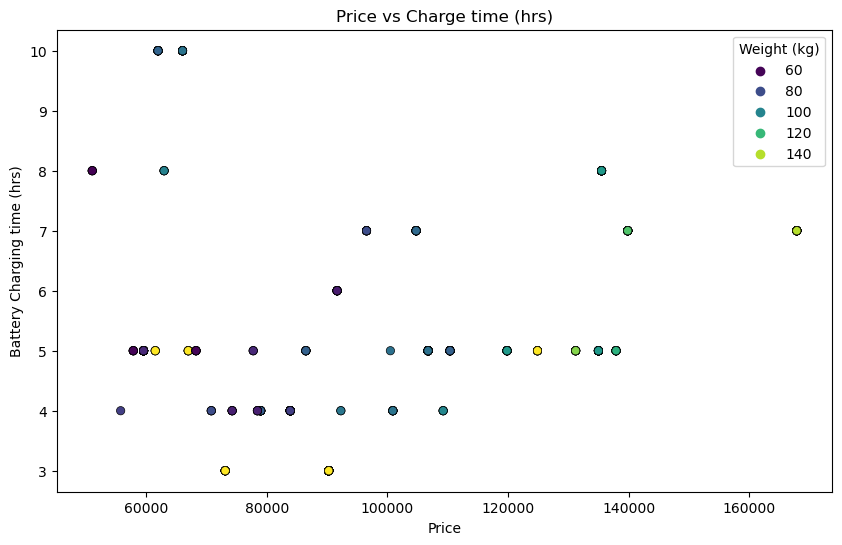

In [103]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data_used,x='Price',y='Battery Charging Time (hrs)',hue='Weight (kg)',palette='viridis',edgecolor='black')

plt.xlabel('Price')
plt.ylabel('Battery Charging time (hrs)')

plt.title('Price vs Charge time (hrs)')
plt.show()

In [111]:
uni_weights = data_used['Weight (kg)'].unique()
print(sorted(uni_weights))

[59, 60, 66, 67, 69, 76, 80, 86, 87, 88, 90, 93, 94, 95, 99, 101, 108, 117, 125, 133, 140, 150]


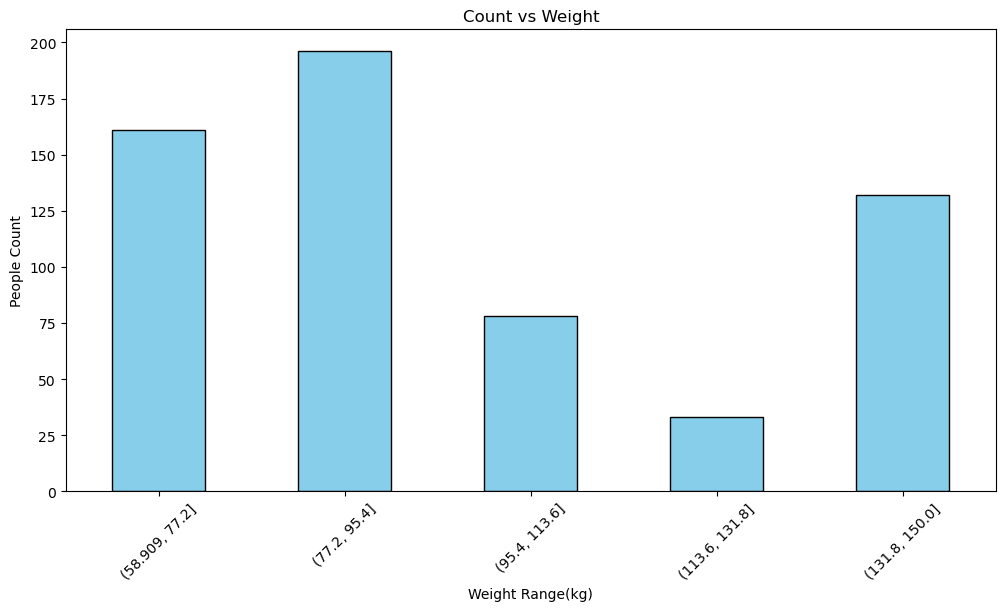

In [116]:
bins = pd.cut(data_used['Weight (kg)'],bins= 5)
bins_counts =bins.value_counts().sort_index()

plt.figure(figsize=(12,6))
bins_counts.plot(kind='bar',color='skyblue',edgecolor='black')

plt.xlabel('Weight Range(kg)')
plt.ylabel('People Count')
plt.title('Count vs Weight')

plt.xticks(rotation=45)
plt.show()

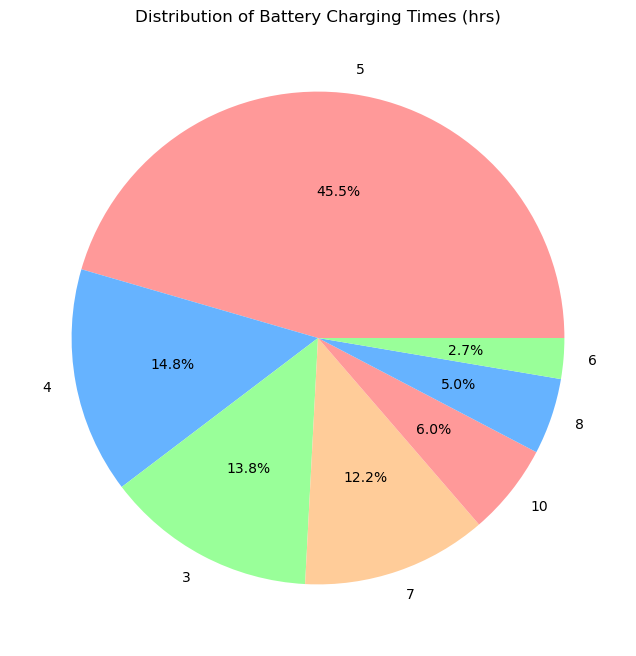

In [127]:
# List of colors for the pie chart
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

Battery_time = data_used['Battery Charging Time (hrs)'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(Battery_time, labels=Battery_time.index, autopct='%1.1f%%',colors=colors)
plt.title('Distribution of Battery Charging Times (hrs)')
plt.show()

 There 45% share of **5 hrs battery** in the market. There is a opportunity of **4 hrs** and **3hrs**.

In [152]:
data_used['sentiment'].unique()

array([-1,  1,  0], dtype=int64)

In [148]:
Sentiment_map = {'positive':1,'negative':-1,'neutral':0}
data_used.loc[:,'sentiment'] = data_used['sentiment'].map(Sentiment_map)
data_used.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_7004\2480429719.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_used.loc[:,'sentiment'] = data_used['sentiment'].map(Sentiment_map)


,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
2,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,1
3,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
4,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1
5,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1


In [149]:
data_5 = data_used[data_used['Battery Charging Time (hrs)']==5]
data_5.head()

,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
2,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,1
3,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,-1
4,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1
5,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,-1


In [150]:
data_34 = data_used[data_used['Battery Charging Time (hrs)'].isin([3, 4])]
data_34.head() 

,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
291,> 1 yr,> 15000 kms,5,5.0,5.0,NaN,5.0,NaN,5.0,NaN,5.0,Bounce Infinity E1,100905,85,65,94,4,1500,1
292,3-6 months,< 5000 kms,5,5.0,5.0,NaN,5.0,NaN,5.0,NaN,5.0,Bounce Infinity E1,100905,85,65,94,4,1500,1
295,< 3 months,< 5000 kms,5,5.0,4.0,NaN,4.0,NaN,5.0,NaN,4.0,Bounce Infinity E1,100905,85,65,94,4,1500,1
297,6 months-1 yr,5000-10000 kms,5,5.0,1.0,NaN,5.0,NaN,5.0,NaN,5.0,Bounce Infinity E1,100905,85,65,94,4,1500,1
298,> 1 yr,< 5000 kms,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bounce Infinity E1,100905,85,65,94,4,1500,-1


In [161]:
print(data_34[['Battery Charging Time (hrs)', 'Price', 'Service Experience', 'Riding Range (km)']].describe())

       Battery Charging Time (hrs)          Price  Service Experience  \
count                   172.000000     172.000000          133.000000   
mean                      3.517442   85869.058140            2.646617   
std                       0.501155    8200.426677            1.610550   
min                       3.000000   55799.000000            1.000000   
25%                       3.000000   78999.000000            1.000000   
50%                       4.000000   83897.000000            2.000000   
75%                       4.000000   90282.000000            4.000000   
max                       4.000000  109242.000000            5.000000   

       Riding Range (km)  
count         172.000000  
mean           98.412791  
std            19.541483  
min            60.000000  
25%            88.000000  
50%            88.000000  
75%           120.000000  
max           150.000000  


In [162]:
data_34_seg = data_34[['Battery Charging Time (hrs)', 'Price', 'Service Experience', 'Riding Range (km)']]
data_34_seg.head() 

,Battery Charging Time (hrs),Price,Service Experience,Riding Range (km)
291,4,100905,5.0,85
292,4,100905,5.0,85
295,4,100905,4.0,85
297,4,100905,5.0,85
298,4,100905,NaN,85


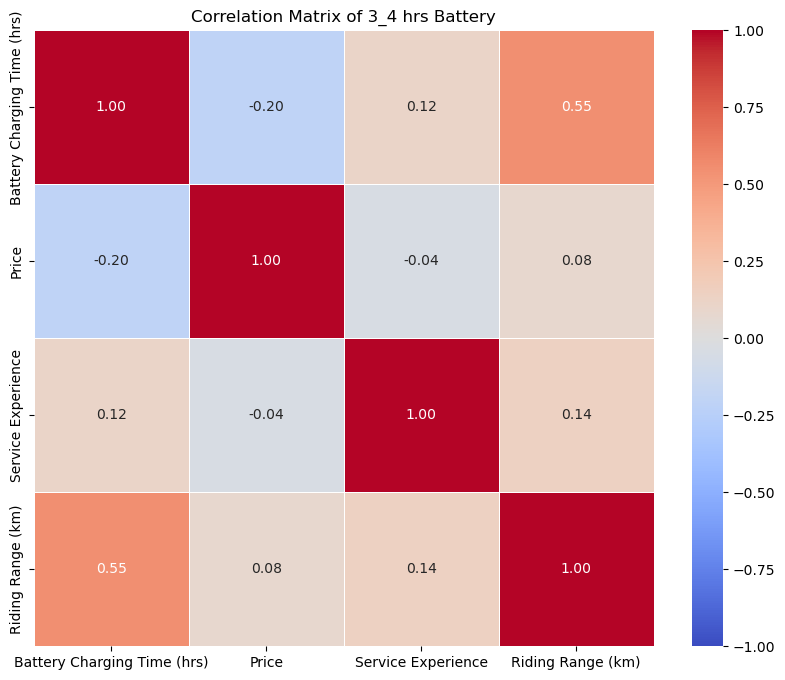

In [163]:
corr_mat_34 = data_34_seg.corr()

# Create heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat_34,annot=True,cmap='coolwarm',vmin=-1,vmax=1,fmt='.2f',linewidths=0.5)
plt.title('Correlation Matrix of 3_4 hrs Battery')
plt.show()

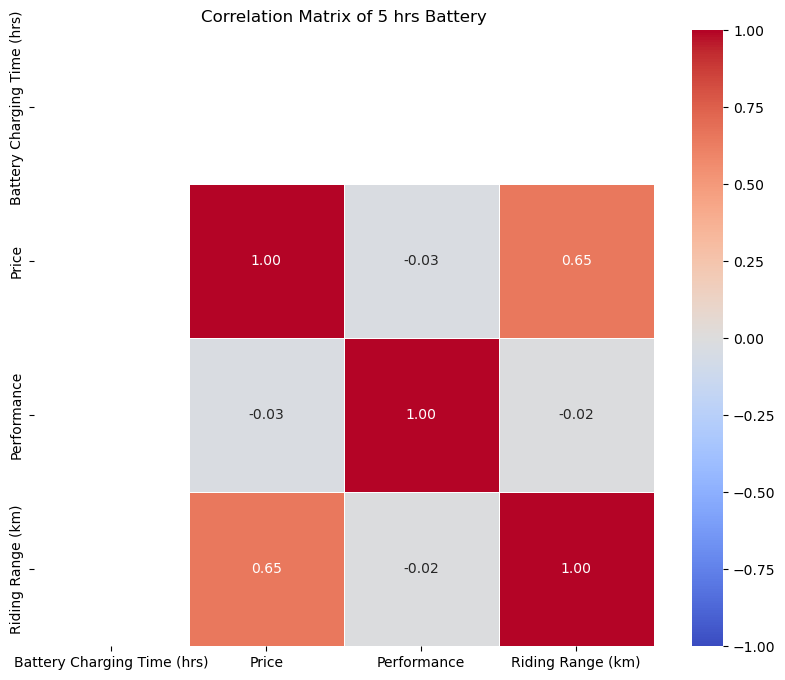

In [160]:
data_5_seg = data_5[['Battery Charging Time (hrs)', 'Price', 'Performance', 'Riding Range (km)']]

corr_mat_5 = data_5_seg.corr()

# Create heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat_5,annot=True,cmap='coolwarm',vmin=-1,vmax=1,fmt='.2f',linewidths=0.5)
plt.title('Correlation Matrix of 5 hrs Battery')
plt.show()

In [153]:
print(data_5[['Battery Charging Time (hrs)', 'Price', 'Performance', 'Riding Range (km)']].describe())

       Battery Charging Time (hrs)          Price  Performance  \
count                        273.0     273.000000    62.000000   
mean                           5.0   96906.633700     3.435484   
std                            0.0   29112.470721     1.477936   
min                            5.0   57893.000000     1.000000   
25%                            5.0   59594.000000     3.000000   
50%                            5.0  106740.000000     4.000000   
75%                            5.0  119827.000000     5.000000   
max                            5.0  137890.000000     5.000000   

       Riding Range (km)  
count         273.000000  
mean          102.417582  
std            27.153864  
min            60.000000  
25%            85.000000  
50%            89.000000  
75%           108.000000  
max           151.000000  


## Before doing anything with the data_used, lets delve into people behaviour and how it give people purchasing scenerio

In [75]:
data_behavior = pd.read_csv('behavioural_segment_data.csv')
data_behavior.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,Total Salary,Price
0,27,Salaried,Single,Post Graduate,0,Yes,800000,800000
1,35,Salaried,Married,Post Graduate,2,Yes,2000000,1000000
2,45,Business,Married,Graduate,4,Yes,1800000,1200000
3,41,Business,Married,Post Graduate,3,No,2200000,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,2600000,1600000


In [76]:
data_behavior.columns

Index(['Age', 'Profession', 'Marrital Status', 'Education', 'No of Dependents',
       'Personal loan', 'Total Salary', 'Price'],
      dtype='object')

In [77]:
data_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               99 non-null     int64 
 1   Profession        99 non-null     object
 2   Marrital Status   99 non-null     object
 3   Education         99 non-null     object
 4   No of Dependents  99 non-null     int64 
 5   Personal loan     99 non-null     object
 6   Total Salary      99 non-null     int64 
 7   Price             99 non-null     int64 
dtypes: int64(4), object(4)
memory usage: 6.3+ KB


### There are four Categorical column is present, and each column only two category there.
So **binary encoding** is appropriate here to convert them into numerical

In [78]:
data_behavior['Profession'].unique()

array(['Salaried', 'Business'], dtype=object)

In [79]:
# Mapping dictionaries
profession_mapping = {'Salaried': 0, 'Business': 1}
marital_status_mapping = {'Single': 0, 'Married': 1}
education_mapping = {'Post Graduate': 1, 'Graduate': 0}
personal_loan_mapping = {'Yes': 1, 'No': 0}

# Apply the mappings
data_behavior['Profession'] = data_behavior['Profession'].map(profession_mapping)
data_behavior['Marrital Status'] = data_behavior['Marrital Status'].map(marital_status_mapping)
data_behavior['Education'] = data_behavior['Education'].map(education_mapping)
data_behavior['Personal loan'] = data_behavior['Personal loan'].map(personal_loan_mapping)

# Display the modified DataFrame
print(data_behavior)

    Age  Profession  Marrital Status  Education  No of Dependents  \
0    27           0                0          1                 0   
1    35           0                1          1                 2   
2    45           1                1          0                 4   
3    41           1                1          1                 3   
4    31           0                1          1                 2   
..  ...         ...              ...        ...               ...   
94   27           1                0          0                 0   
95   50           0                1          1                 3   
96   51           1                1          0                 2   
97   51           0                1          1                 2   
98   51           0                1          1                 2   

    Personal loan  Total Salary    Price  
0               1        800000   800000  
1               1       2000000  1000000  
2               1       1800000  1200000  

In [81]:
data_behavior.isnull().sum()

Age                 0
Profession          0
Marrital Status     0
Education           0
No of Dependents    0
Personal loan       0
Total Salary        0
Price               0
dtype: int64

### Which tells there is no null value in any column.

In [84]:
data_behavior.describe()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,Total Salary,Price
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,9.900000e+01,9.900000e+01
mean,36.313131,0.353535,0.848485,0.565657,2.181818,0.323232,2.270707e+06,1.194040e+06
std,6.246054,0.480500,0.360375,0.498193,1.335265,0.470091,1.050777e+06,4.376955e+05
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+05,1.100000e+05
25%,31.000000,0.000000,1.000000,0.000000,2.000000,0.000000,1.550000e+06,8.000000e+05
50%,36.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.100000e+06,1.200000e+06
75%,41.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.700000e+06,1.500000e+06
max,51.000000,1.000000,1.000000,1.000000,4.000000,1.000000,5.200000e+06,3.000000e+06


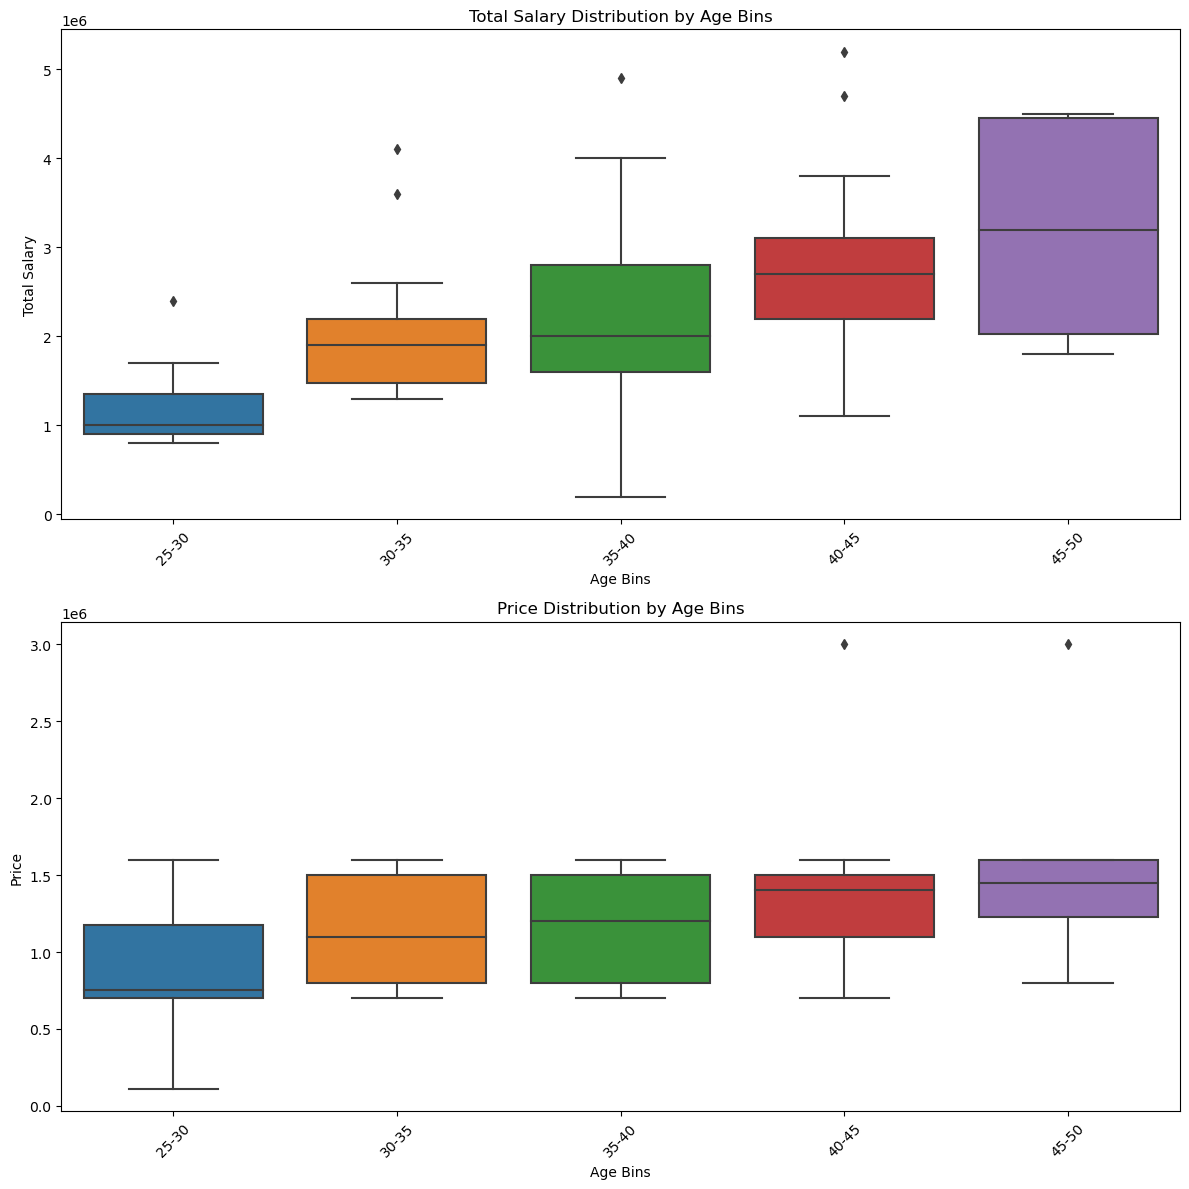

In [91]:
bin_edges = range(25,55,5)
bin_labels = [f'{i}-{i+5}' for i in range(25,50,5)]

bins = pd.cut(data_behavior['Age'], bins = bin_edges, labels=bin_labels,right=False)

# # Group by the bins and calculate the mean salary for each bin
# average_salary_bin = data_behavior.groupby(bins)['Total Salary'].mean().reset_index()

# average_salary_bin['Age'] = average_salary_bin['Age'].astype(str)
# # Plot the results


# Create the figure and two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the first box plot (Total Salary)
sns.boxplot(x=bins, y=data_behavior['Total Salary'], ax=axes[0])
axes[0].set_xlabel('Age Bins')
axes[0].set_ylabel('Total Salary')
axes[0].set_title('Total Salary Distribution by Age Bins')
axes[0].tick_params(axis='x', rotation=45)

# Plot the second box plot (Price)
sns.boxplot(x=bins, y=data_behavior['Price'], ax=axes[1])
axes[1].set_xlabel('Age Bins')
axes[1].set_ylabel('Price')
axes[1].set_title('Price Distribution by Age Bins')
axes[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

### From this Box-whisker plot, people are more tend to buy bike whose price range is 1 lakh to 1.5 lakh

In [40]:
data_used_segment = data_used[[ 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'PerforValueError: Bin labels must be one fewer than the number of bin edgesmance', 'Service Experience', 'Comfort', 'Maintenance cost', 'Value for Money', 'Price','Battery Charging Time (hrs)',
       'sentiment']].copy()

In [ ]:
data_used_segment.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Comfort,Maintenance cost,Value for Money,Price,Battery Charging Time (hrs),sentiment
0,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,4.0,NaN,1.0,137890,5,negative
2,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,5.0,NaN,2.0,137890,5,positive
3,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,1.0,NaN,1.0,137890,5,negative
4,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,3.0,NaN,2.0,137890,5,negative
5,Daily Commute,> 1 yr,5000-10000 kms,1,5.0,1.0,NaN,1.0,5.0,NaN,2.0,137890,5,negative


In [ ]:
data_used_segment.describe()

,rating,Visual Appeal,Reliability,Performance,Service Experience,Comfort,Maintenance cost,Value for Money,Price,Battery Charging Time (hrs)
count,600.000000,524.000000,507.000000,241.000000,500.000000,366.000000,139.000000,281.000000,600.000000,600.00000
mean,3.228333,3.708015,3.187377,3.448133,3.014000,3.516393,3.460432,3.259786,96755.058333,5.29500
std,1.697351,1.363500,1.572490,1.479867,1.612142,1.411694,1.358101,1.511900,28755.345917,1.75588
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51094.000000,3.00000
25%,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,2.500000,2.000000,73124.000000,4.00000
50%,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,90282.000000,5.00000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,110376.000000,6.00000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,167844.000000,10.00000


In [ ]:
data_used_segment.columns

Index(['Used it for', 'Owned for', 'Ridden for', 'rating', 'Visual Appeal',
       'Reliability', 'Performance', 'Service Experience', 'Comfort',
       'Maintenance cost', 'Value for Money', 'Price',
       'Battery Charging Time (hrs)', 'sentiment'],
      dtype='object')

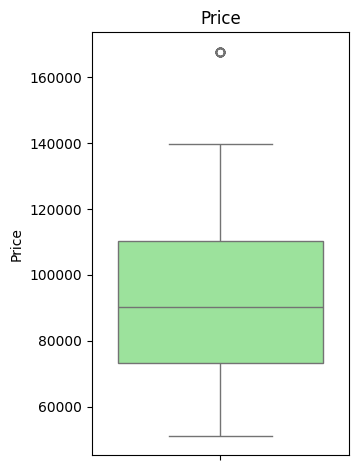

In [ ]:
## Box Plot for Battery Charging Time
plt.subplot(1, 2, 2)
sns.boxplot(y=data_used_segment['Price'], color='lightgreen')
plt.title('Price')
#plt.ylabel('Price')

plt.tight_layout()
plt.show()

In [ ]:
data_segment = data.iloc[:, 5:13].copy()

In [ ]:
data_segment = data_segment.fillna(0.)

In [ ]:
data_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Visual Appeal       844 non-null    float64
 1   Reliability         844 non-null    float64
 2   Performance         844 non-null    float64
 3   Service Experience  844 non-null    float64
 4   Extra Features      844 non-null    float64
 5   Comfort             844 non-null    float64
 6   Maintenance cost    844 non-null    float64
 7   Value for Money     844 non-null    float64
dtypes: float64(8)
memory usage: 52.9 KB


In [ ]:
data_segment.mean()

Visual Appeal         3.309242
Reliability           2.811611
Performance           1.441943
Service Experience    2.619668
Extra Features        0.643365
Comfort               2.300948
Maintenance cost      0.723934
Value for Money       1.562796
dtype: float64

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_segment)

In [ ]:
pca = PCA(random_state = 42)
pca.fit(data_scaled)

PCA(random_state=42)

In [ ]:
data_pca = pca.transform(data_scaled)

In [ ]:
df_pca = pd.DataFrame(data_pca, columns = [f'PC{x +1}' for x in range(len(data_segment.columns))])

In [ ]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.291227,-1.038055,0.354864,-0.623469,-1.102720,-0.169287,-0.438012,0.957827
1,0.710801,-1.394405,-0.360466,-0.621671,0.320899,-0.086053,-0.426279,-0.149917
2,-0.849149,-1.189765,0.167683,-0.410898,-0.409054,-0.191904,-0.329993,0.830738
3,1.967022,-0.878935,-0.100197,0.330003,-0.075822,0.069599,0.013068,0.011328
4,0.078940,-1.017161,-0.079210,-0.324132,-0.961554,0.005517,-0.107260,0.427972


In [ ]:
pca_summary = pd.DataFrame({'Standard Deviation':df_pca.std(),
                           'Proportion of Variance': pca.explained_variance_ratio_,
                           'Cumultive Proportion': pca.explained_variance_ratio_.cumsum()})

In [ ]:
pca_summary

,Standard Deviation,Proportion of Variance,Cumultive Proportion
PC1,1.845017,0.425007,0.425007
PC2,1.736646,0.376546,0.801553
PC3,0.903486,0.101915,0.903468
PC4,0.517750,0.033468,0.936936
PC5,0.405239,0.020503,0.957439
PC6,0.379558,0.017987,0.975426
PC7,0.337883,0.014254,0.989680
PC8,0.287510,0.010320,1.000000


In [ ]:
factor_loadings = pd.DataFrame(pca.components_, columns = data_segment.columns, index = df_pca.columns).T

In [ ]:
factor_loadings.style.background_gradient(cmap = 'Blues')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Visual Appeal,-0.480170,0.117814,0.063320,-0.730598,0.247014,0.105903,0.375474,0.067539
Reliability,-0.494758,0.124910,-0.002776,0.152447,-0.819319,0.060484,0.117211,0.166384
Performance,-0.128721,0.459145,0.574833,-0.005549,-0.019902,-0.025704,-0.288468,-0.598232
Service Experience,-0.486499,0.100691,-0.054176,0.653781,0.470391,0.052432,0.311210,-0.044129
Extra Features,-0.024373,0.519633,-0.364578,-0.023208,0.116821,0.559390,-0.456829,0.246323
Comfort,-0.418255,-0.304266,0.249807,-0.020111,0.172621,-0.296656,-0.623271,0.404238
Maintenance cost,0.005912,0.513208,-0.386495,-0.054822,0.020302,-0.762039,-0.003360,0.055435
Value for Money,-0.309572,-0.351548,-0.563840,-0.107598,-0.046688,0.009572,-0.260855,-0.617065


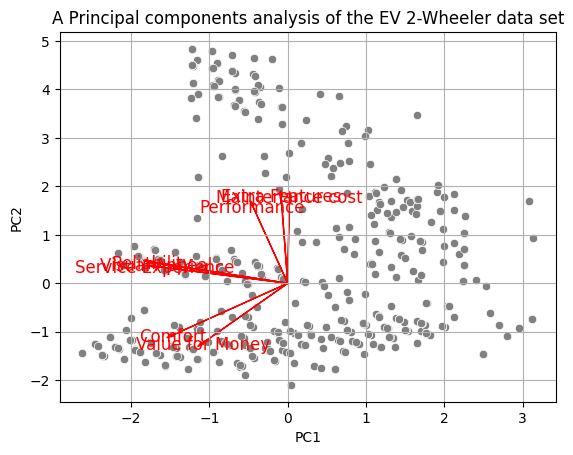

In [ ]:
# Calculate centroid
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(df_pca, x = 'PC1', y = 'PC2', color = 'grey')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text((factor_loadings['PC1'][i] * 3.5), factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')

# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('A Principal components analysis of the EV 2-Wheeler data set')
plt.grid(True)
plt.show()

In [ ]:
data_km28 = [KMeans(n_clusters = k, random_state = 42).fit(data_scaled) for k in range(2, 9)]

In [ ]:
wcss = [model.inertia_ for model in data_km28]

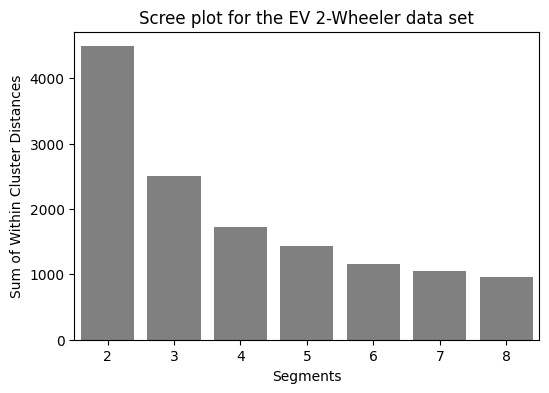

In [ ]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x = list(range(2, 9)), y = wcss, color = 'grey')
plt.xlabel("Segments")
plt.ylabel('Sum of Within Cluster Distances')
plt.title("Scree plot for the EV 2-Wheeler data set")
plt.show()

In [ ]:
wcss_diff = pd.DataFrame({'Segments':range(2,9),
                          'WCSS Difference': pd.Series(wcss).diff()})
wcss_diff['WCSS Difference'][0] = 0

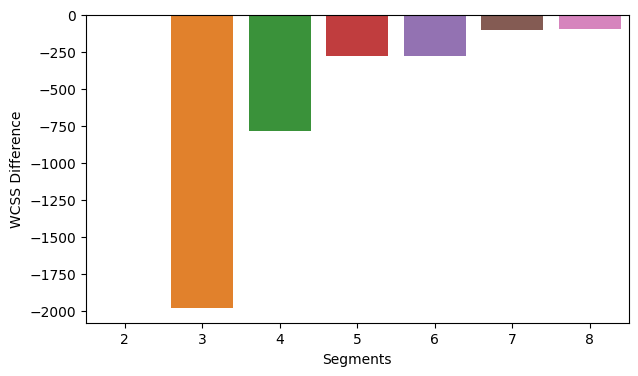

In [ ]:
plt.figure(figsize = (7, 4))
sns.barplot(wcss_diff, x = 'Segments', y = 'WCSS Difference')
plt.show()

**The decision-making process was significantly guided by the scree plot above, revealing a distinct elbow at four segments. This marked point indicated a substantial reduction in distances, signifying the optimal number of segments for our analysis.**

In [ ]:
kmeans = data_km28[2]

In [ ]:
data_clust = pd.DataFrame(data_scaled, columns = data_segment.columns)
data_clust['cluster'] = kmeans.labels_

In [ ]:
data_pca = df_pca.copy()
data_pca['cluster'] = kmeans.labels_

# Profiling Segments

In [ ]:
data_profile = data_segment.copy()
data_profile['cluster'] = kmeans.labels_

In [ ]:
columns_segment = data_clust.columns
data_pivot = data_profile[columns_segment].groupby('cluster').mean().T

In [ ]:
data_pivot_mean = data_pivot.mean(axis = 1).reset_index()
data_pivot_mean.columns = ['Variable', 'Value']

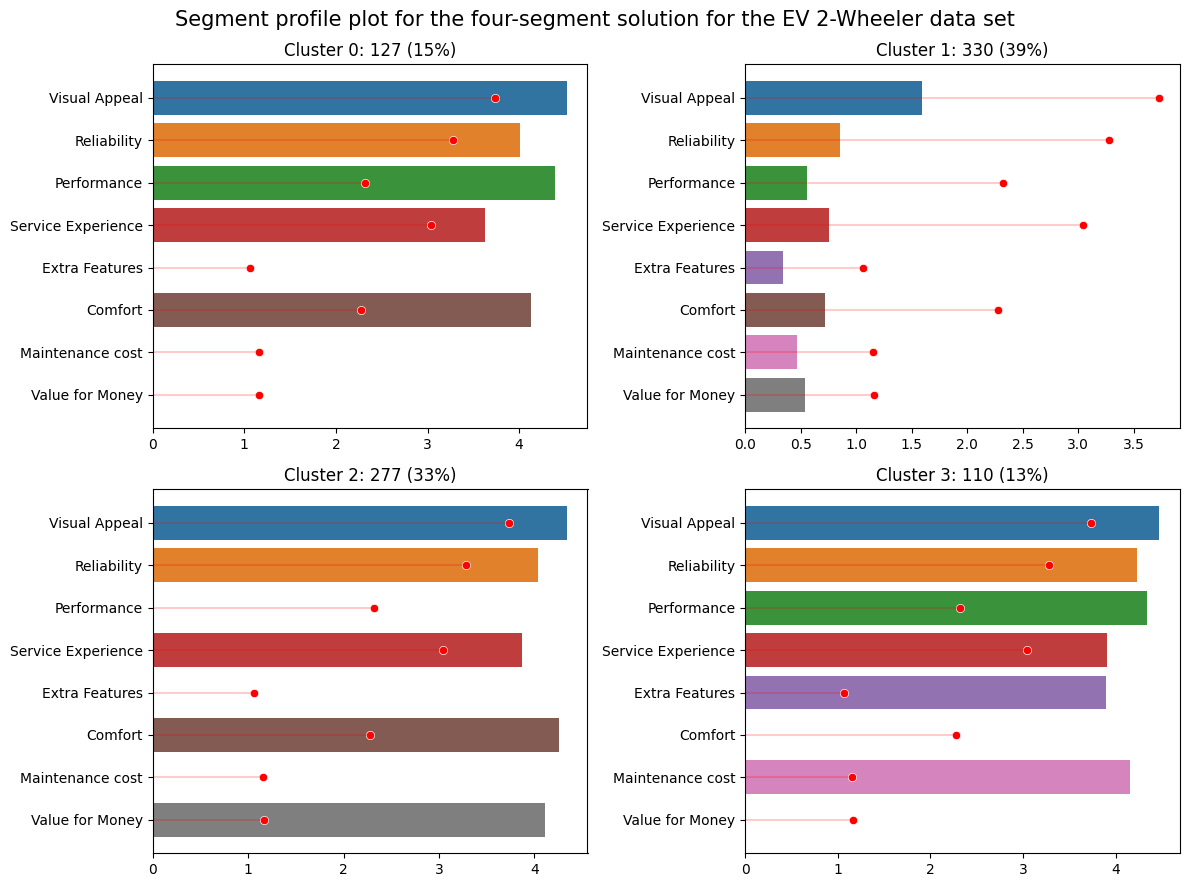

In [ ]:
plt.figure(figsize = (12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.barplot(data_pivot, x = i, y = data_pivot.index)
    sns.scatterplot(data_pivot_mean, x = 'Value', y = 'Variable', color = 'red')
    for index, row in data_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='red', alpha = 0.2)
    plt.ylabel("")
    plt.xlabel("")
    plt.title(f"Cluster {i}: {data_profile['cluster'].value_counts()[i]} ({data_profile['cluster'].value_counts()[i]*100/len(data_profile):.0f}%)")
plt.suptitle("Segment profile plot for the four-segment solution for the EV 2-Wheeler data set", fontsize = 15)
plt.tight_layout()
plt.show()

**Above graph visually captures the diverse perceptions among different segments. Segment 0, representing 15% of consumers, values the electric two-wheeler vehicle for its visual appeal, reliability, performance, service experience, and comfort. Conversely, Segment 1 (39% of consumers) expresses dissatisfaction across all aspects, marking them as the largest but least satisfied group. Segment 2 (33% of consumers) appreciates visual appeal, reliability, service experience, comfort, and notably, perceives a strong value for money. Lastly, Segment 3 (13% of consumers), the smallest segment, values visual appeal, reliability, performance, service experience, extra features, and maintenance cost, showcasing distinct perceptions, particularly on features and costs.**

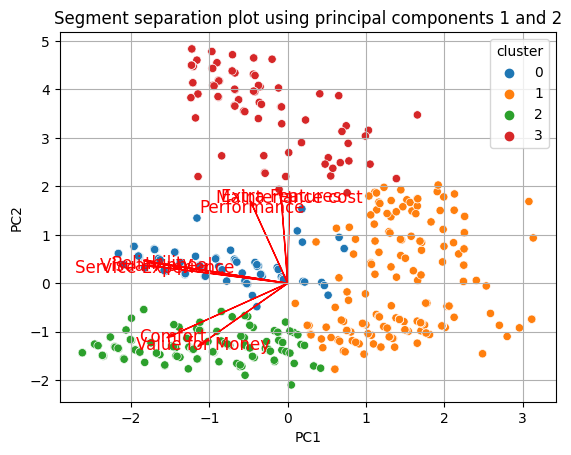

In [ ]:
# Calculate centroid
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(data_pca, x = 'PC1', y = 'PC2', hue = 'cluster', palette = 'tab10')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text(factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')

# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Segment separation plot using principal components 1 and 2')
plt.grid(True)
plt.show()

**Above Figure, utilizing principal components, further emphasizes the differences among segments. Notably, Segment 1, despite being the largest segment, lacks specific opinions, making them unique in their lack of satisfaction.**

# Describing Segments

In [ ]:
data_desc = data.copy()
data_desc['cluster'] = kmeans.labels_

In [ ]:
data_desc.columns

Index(['review', 'Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'Model Name', 'Price', 'Riding Range (km)', 'Top Speed (kmph)',
       'Weight (kg)', 'Battery Charging Time (hrs)', 'Rated Power (W)',
       'sentiment', 'cluster'],
      dtype='object')

In [ ]:
def mosaicplot(df, color_list, figsize=(5,5), barwidth = 1, title = "Simple Mosaic Plot", xlabel = 'cat'):

    fig, ax = plt.subplots(figsize =figsize)

    # Convert to ratio of each row sum and do a cumsum along row
    p_cnt_ratio_df = df.div(df.sum(1), axis =0)
    ratio_cum_df = p_cnt_ratio_df.cumsum(axis=1)

    # Get column order.
    col_order = ratio_cum_df.columns.tolist()

    x = [str(n) for n in ratio_cum_df.index.tolist()]

    # Do the actual plots
    for col, colour in zip(col_order[::-1], color_list):
        plt.bar(x, ratio_cum_df[col], color=colour, edgecolor='white', width=barwidth, label=col)

    # Add in legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)


    # Configure title and axis
    plt.title(title)
    plt.xlabel("Segments")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([])
    plt.show()


In [ ]:
color_list = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F']

In [ ]:
sentiment_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['sentiment'])

In [ ]:
sentiment_cluster

sentiment,negative,neutral,positive
cluster,,,
0,12,4,111
1,202,7,121
2,30,41,206
3,14,0,96


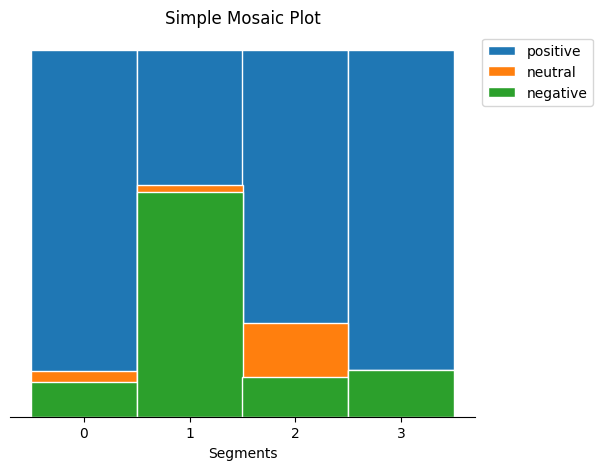

In [ ]:
mosaicplot(sentiment_cluster, color_list[:3], figsize=(6,5), barwidth = 1)

**Above mosaic plot, explores consumer sentiments, revealing that all segments, except Segment 1, exhibit positive sentiments. Segment 1 consumers stand out with negative sentiments, indicating dissatisfaction across various aspects.**

In [ ]:
used_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Used it for'])

In [ ]:
used_cluster

Used it for,Daily Commute,Everything,Leisure Rides,Occasional Commute,Tours
cluster,,,,,
0,75,39,4,9,0
1,244,47,7,27,5
2,194,55,7,19,2
3,87,19,2,1,1


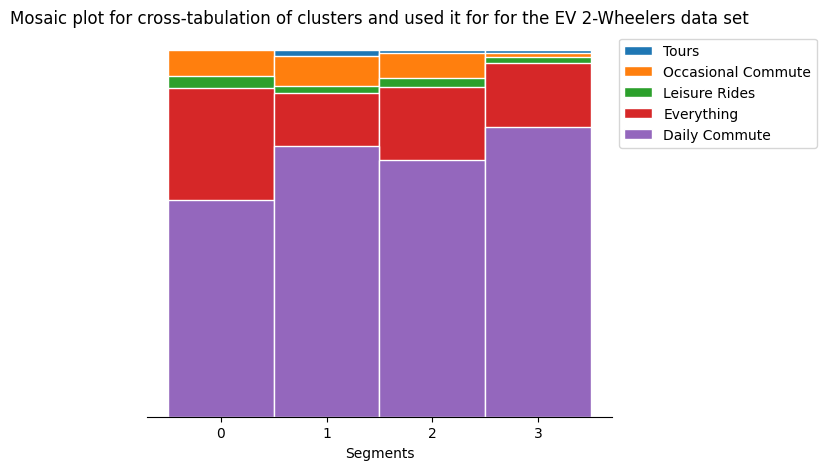

In [ ]:
mosaicplot(used_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and used it for for the EV 2-Wheelers data set' )

**Above mosaic plot illustrates that all segments predominantly use electric vehicles for daily commuting, with limited usage for tours, occasional commuting, and leisure rides.**

In [ ]:
owned_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Owned for'])

In [ ]:
owned_cluster

Owned for,3-6 months,6 months-1 yr,< 3 months,> 1 yr,Never owned,Occasional Commute
cluster,,,,,,
0,16,14,31,10,56,0
1,40,55,67,117,50,1
2,41,51,79,56,50,0
3,14,14,43,20,19,0


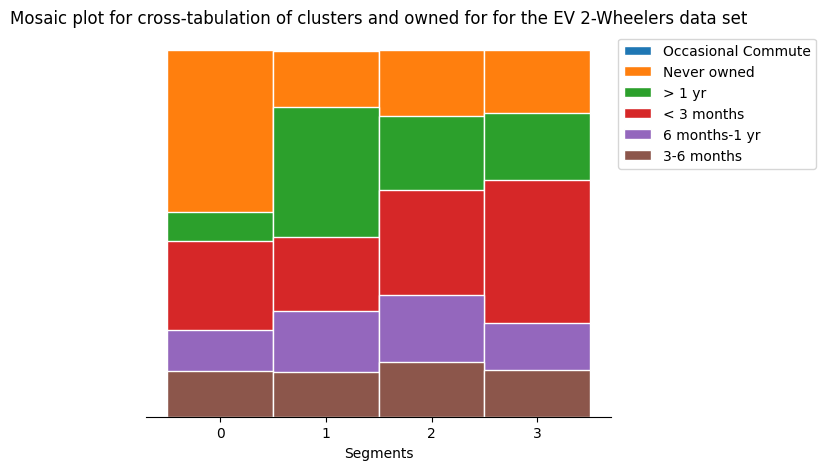

In [ ]:
mosaicplot(owned_cluster, color_list[:6], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and owned for for the EV 2-Wheelers data set' )

**Above mosaic plot delineates the ownership duration of electric vehicles among segments. Segment 1 stands out, owning electric vehicles for more than a year, while Segment 0 has no prior ownership experience. Segment 2 members moderately own vehicles ranging from less than 3 months to over a year, and Segment 3 consumers have owned electric vehicles for a few days to less than 3 months.**

In [ ]:
ridden_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Ridden for'])

In [ ]:
ridden_cluster

Ridden for,10000-15000 kms,5000-10000 kms,< 5000 kms,> 15000 kms,Never owned
cluster,,,,,
0,1,15,54,1,0
1,15,61,184,18,1
2,11,44,158,14,0
3,5,18,63,5,0


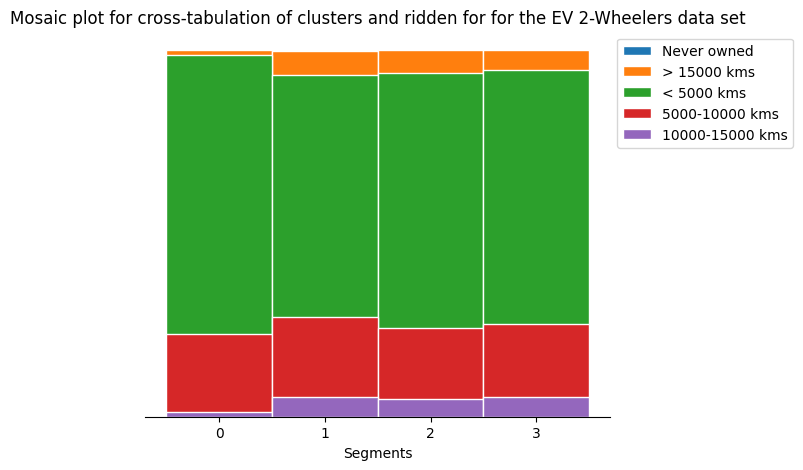

In [ ]:
mosaicplot(ridden_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and ridden for for the EV 2-Wheelers data set' )

**Above mosaic plot delves into the distances covered by consumers, indicating that all segments predominantly use electric vehicles for commuting, with most users covering distances below 5000 kms. A small portion falls in the 5000 to 10000 kms range, aligning with their commuting needs.**

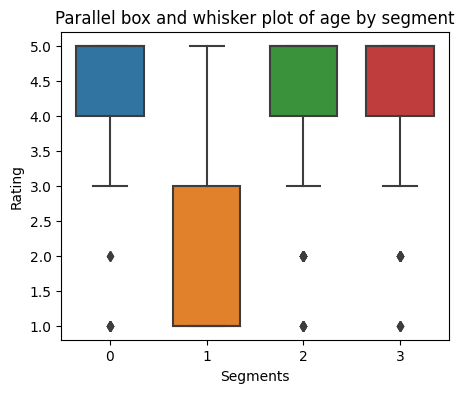

In [ ]:
# Number of cluster along the x-axis and rating along the y-axis
plt.figure(figsize = (5,4))
sns.boxplot(data_desc, x= 'cluster', y = 'rating', palette = 'tab10', width = 0.7)
plt.xlabel("Segments")
plt.ylabel("Rating")
plt.title("Parallel box and whisker plot of age by segment")
plt.savefig("rating.png")
plt.show()

**Above parallel box and whisker plot, emphasizes significant differences in average ratings among segments. Specifically, Segment 1 consumers express dissatisfaction across all perceptions, leading to lower overall ratings.**

In [ ]:
data_desc.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment,cluster
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative,1
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000,negative,1
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,positive,2
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative,1
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative,2


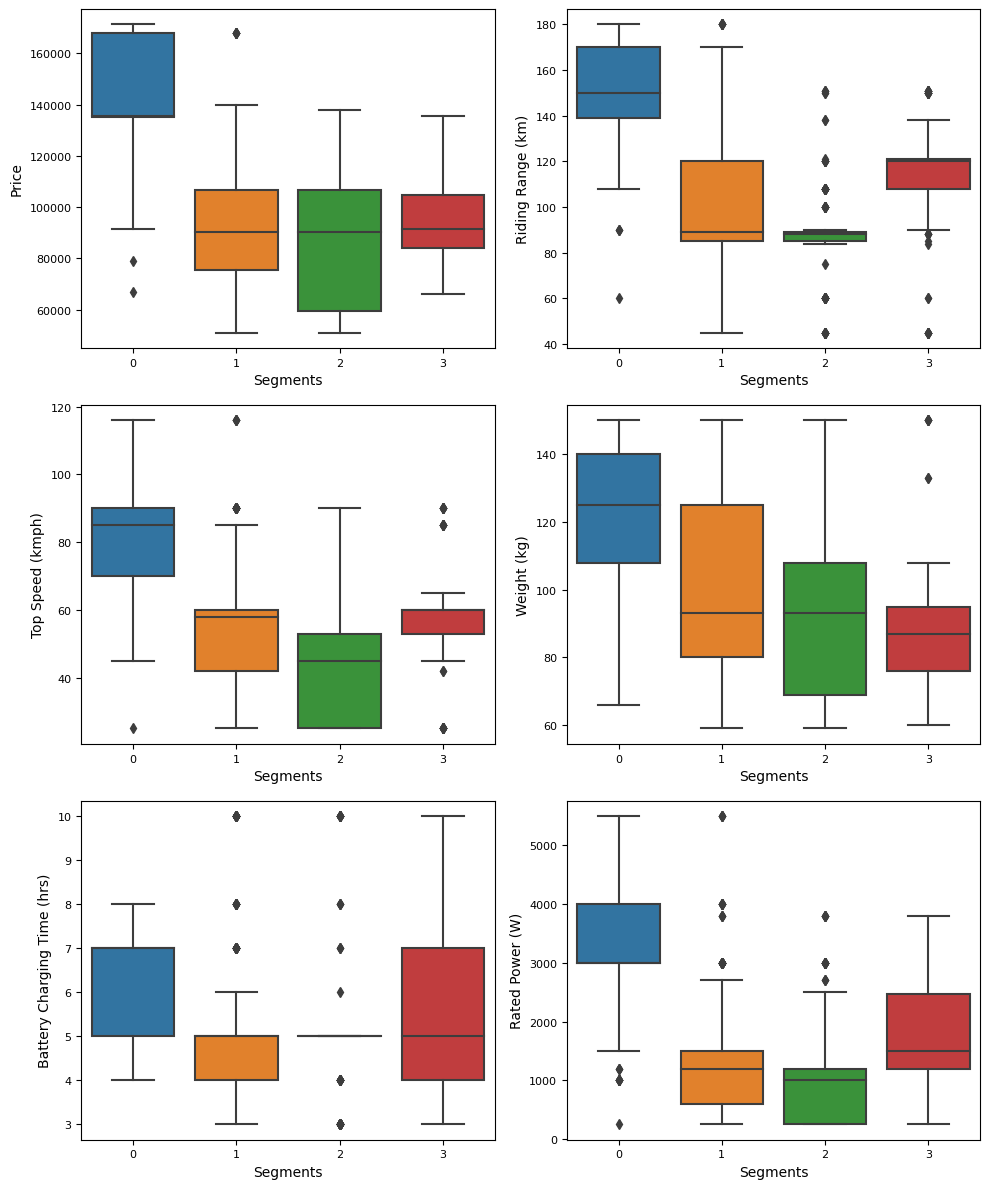

In [ ]:
plt.figure(figsize = (10, 12))
for i, col in enumerate(data_desc.columns[-8:-2]):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data_desc, x = 'cluster', y =col)
    plt.xlabel("Segments", fontsize= 10)
    plt.ylabel(col, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

**In analyzing technical specification of electric vehicles across different segments, distinct patterns emerge. Segment 0 prefers premium EVs with a higher price range and extended riding range, emphasizing consumer preference for luxury and long-distance travel. Segment 1 focuses on budget-friendly options with lower prices and moderate riding ranges, suitable for daily commuting. Segment 2 and Segment 3 prioritize affordability, with slight differences in riding range and speed preferences. Weight preferences vary, with Segment 0 and Segment 1 favoring heavier vehicles, while Segment 2 and Segment 3 prefer lighter options. Charging time also differs, with Segment 0 and Segment 3 opting for longer durations for overnight charging, while Segment 1 and Segment 2 prioritize faster charging for quick turnaround times. These nuanced preferences shape the electric vehicle market in India.**

# Selection of Target Segment

The strategic target segments for the electric vehicle market are identified as Segment 1 (39% of consumers) and Segment 2 (33% of consumers). Segment 1's diverse preferences and dissatisfaction points present an opportunity for improving customer satisfaction and loyalty by directly addressing their specific demands. Segment 2 values visual appeal, reliability, service experience, and comfort, offering a chance to customize electric vehicles to meet these expectations and emphasize value for money. The strategy involves addressing dissatisfaction points in Segment 1 and enhancing positive elements in Segment 2, aligning electric vehicles with the distinct expectations of each segment to ensure competitive advantage and sustained market growth.

# Customizing the Marketing Mix


In our electric vehicle market strategy, customization of the marketing mix is crucial for appealing to Segment 1 and Segment 2, our target segments.
* Product customization involves enhancing features based on specific desires, addressing dissatisfaction points for Segment 1, and emphasizing visual appeal and value for money for Segment 2. Diverse offerings cater to varied tastes and budgets within each segment.
* Price customization includes competitive pricing for Segment 1 and a slightly higher price point for value-added features in Segment 2.
* Promotion customization focuses on targeted advertising and tailored promotional events for each segment's preferences.
* Place customization establishes accessible distribution channels in urban areas for Segment 1 and suburban/semi-urban regions for Segment 2, with a strong emphasis on online presence and customer support.
* People and Process Customization involves training customer service representatives to address segment-specific concerns and ensuring efficient processes for customization requests and service appointments.
This tailored approach ensures our electric vehicles align with the distinct needs of Segment 1 and Segment 2, enhancing market relevance and customer preference.

# Potential Early Market Customer Base

In the analysis of the early market customer base, two primary segments are identified: Segment 1 with 330 members (39% of consumers) and Segment 2 with 277 members (33% of consumers). The target price range for Segment 1 falls between ₹51,094 and ₹1,67,844, and for Segment 2, it ranges from ₹51,094 to ₹1,37,890. By multiplying the number of potential customers in each segment by the targeted price range, potential profits can be calculated. For example, with a target price of ₹1,20,000 for Segment 1, the potential profit amounts to ₹39.60 crores, and for Segment 2 with a target price of ₹1,10,000, the potential profit is ₹30.47 crores. Segment 1, being larger in potential market share, is the primary focus for early market penetration efforts due to its significant profit opportunity.

# Most Optimal Market Segments


After thorough analysis and evaluation, Segment 1, constituting 39% of consumers, has been identified as the optimal market segment for electric two-wheeler vehicles. With a significant customer base and a balanced blend of technical specifications and price range, this segment offers substantial market potential. The recommended technical specifications for Segment 1 include a price range of ₹70,688 to ₹1,29,063, riding range of 89 to 180 km, top speed of 58 to 116 kmph, weight of 76 to 120 kg, battery charging time of 3 to 5 hours, and rated power of 1200 to 5500 W. This targeted approach ensures alignment with the diverse needs and preferences of the market, laying the foundation for a successful and sustainable venture into the electric vehicle market.

# Conclusion

In summary, our in-depth analysis of India's electric vehicle market led us to identify Segment 1 as the optimal target. With a significant 39% consumer base, this segment represents a substantial market opportunity. By tailoring our electric two-wheeler specifications to meet the preferences of this segment, we ensure our products align seamlessly with the demands of a large customer base. This strategic decision is grounded in a thorough understanding of market segmentation, consumer behavior, and technical specifications.
These insights provide a clear direction for our market entry, emphasizing precision and relevance in both product development and marketing strategies. Moving forward, this approach equips us with a solid foundation, ensuring our offerings resonate effectively within India's evolving electric vehicle landscape.